In [1]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [2]:
DIR_TRAIN = "/media/yuri/A/constr_engi/train_dataset/train/"
DIR_TEST = "/media/yuri/A/constr_engi/test_dataset/test/"

PATH_TRAIN ="/media/yuri/A/constr_engi/train_dataset/train1.csv"
PATH_TEST = "/media/yuri/A/constr_engi/test_dataset/test.csv"

In [3]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']

        # читаем картинку. read the image
        image = cv2.imread(DIR_TRAIN + f"{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [4]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

Загруим датасет как архив и откроем его 

In [6]:
!unzip МФТИ.zip -d /content/МФТИ/

unzip:  cannot find or open МФТИ.zip, МФТИ.zip.zip or МФТИ.zip.ZIP.


In [5]:
# читаем датасет
data_df = pd.read_csv(PATH_TRAIN)

In [6]:
data_df.head(3)

,ID_img,class
0,2138.jpg,4.0
1,2139.jpg,6.0
2,2140.jpg,3.0


In [8]:
data_df.tail()

,ID_img,class
8935,web_3945.jpg,0.0
8936,web_3946.jpg,0.0
8937,web_3947.jpg,0.0
8938,web_3948.jpg,0.0
8939,web_3949.jpg,0.0


In [9]:
from os import listdir

print("Обучающей выборки " ,len(listdir(DIR_TRAIN)))
print("Тестовой выборки " ,len(listdir(DIR_TEST)))

Обучающей выборки  8940
Тестовой выборки  2138


In [10]:
from os import listdir

print("Обучающей выборки " ,len(listdir(DIR_TRAIN)))
print("Тестовой выборки " ,len(listdir(DIR_TEST)))

Обучающей выборки  8940
Тестовой выборки  2138


<AxesSubplot:xlabel='class', ylabel='count'>

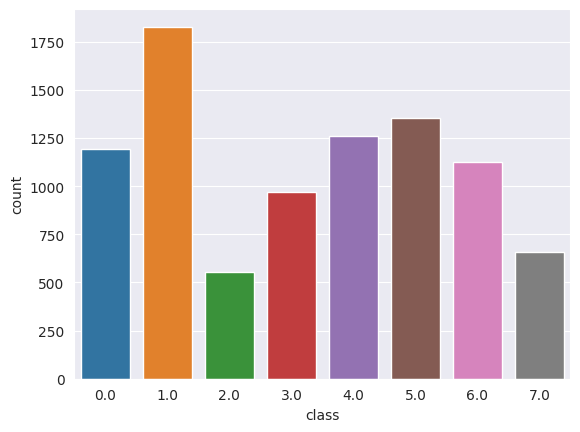

In [11]:
import seaborn as sns
import warnings

warnings.simplefilter('ignore')
sns.countplot(x = "class" , data  = data_df)

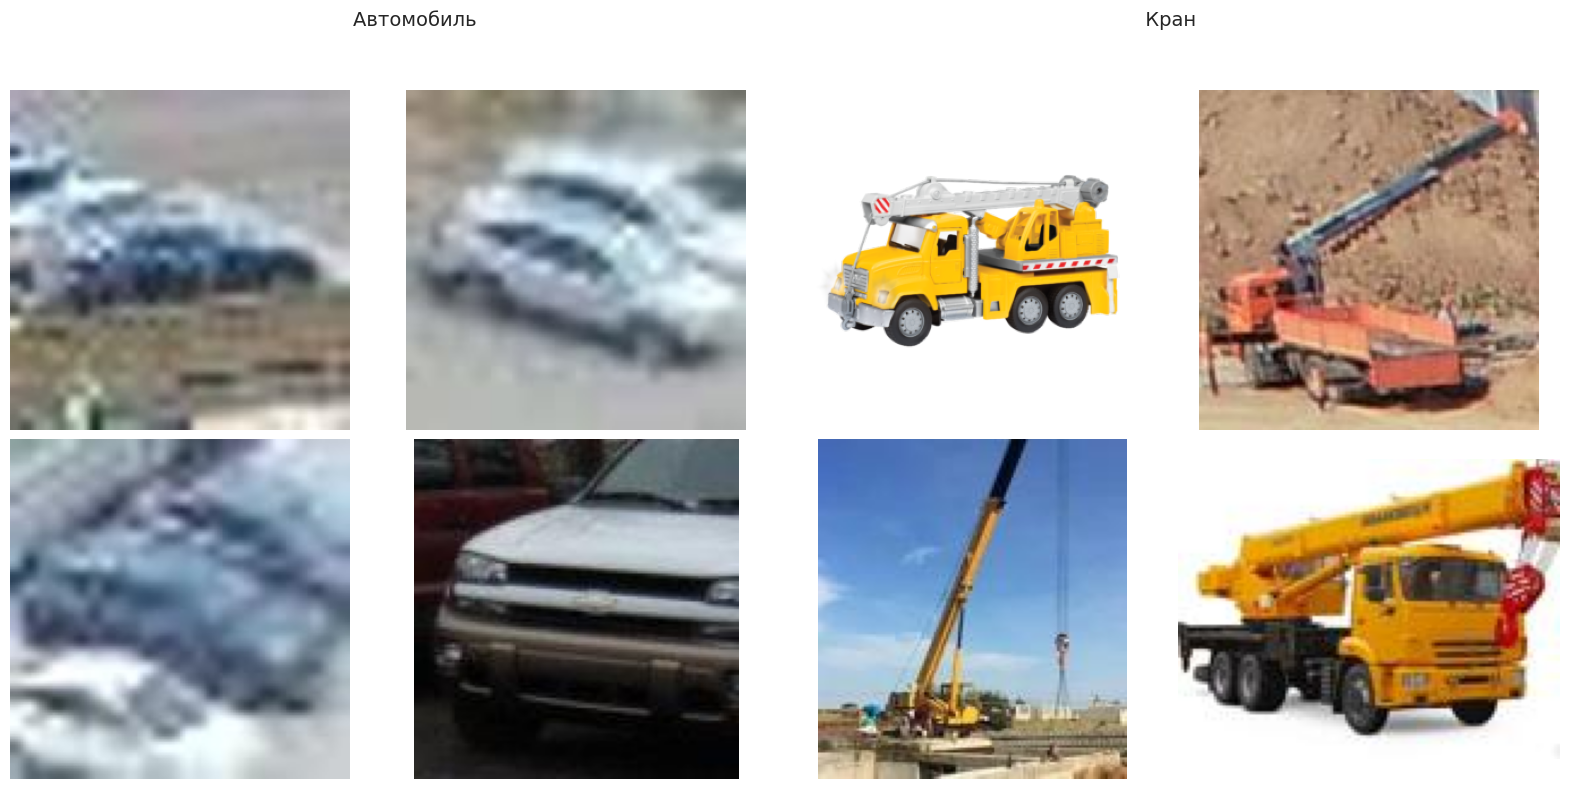

In [12]:
# посмотрим на картинки. Не забудем указать корретный путь до папки

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Автомобиль {" "*105} Кран', fontsize=14)

for i, name in zip(range(4), data_df[ data_df['class'] == 1 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)].imshow(plt.imread(DIR_TRAIN + f"{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['class'] == 0 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(DIR_TRAIN + f"{name}"))
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [13]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=43)

In [14]:
train_df.shape, valid_df.shape

((7152, 2), (1788, 2))

In [15]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=32,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

## Вспомогательные функции

In [17]:
def crossvalid(res_model=None,criterion=None,optimizer=None,dataset=None,k_fold=5):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc
        val_acc = valid(res_model,criterion,optimizer,val_loader)
        val_score.at[i] = val_acc
    
    return train_score,val_score

In [18]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    dd = list(map(lambda x: x.cpu().detach().numpy(), train_history))
    plt.plot(dd, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]

    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [19]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            train_pred += (y_pred.argmax(1) == labels).sum()

            optimizer.step()

        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred.argmax(1) == labels).sum()
        

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        


        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

## Модель

Если надо почистить память

In [20]:
import gc

gc.collect()

239

In [21]:
torch.cuda.empty_cache()

In [22]:
# Подргружаем модель установим выход раный числу классов

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 8)

model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

In [23]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

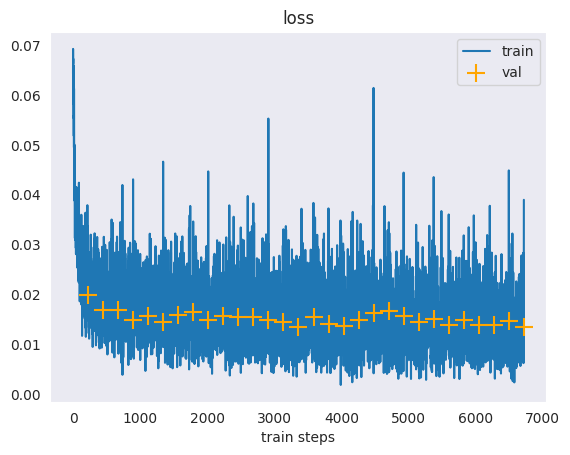

100%|██████████| 30/30 [15:28<00:00, 30.95s/it]

Train loss: 1.4279004153055899
Val loss: 1.359736170178025
Train acc: tensor(85.0252, device='cuda:0')
Val acc: tensor(85.9620, device='cuda:0')


In [24]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
                                                                 criterion, 
                                                                optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 30)

In [28]:
# torch.save(model,'/home/yuri/PycharmProjects/constr_engi/models/model0.pt')
n=torch.load('/home/yuri/PycharmProjects/constr_engi/models/model0.pt')

In [29]:
n

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

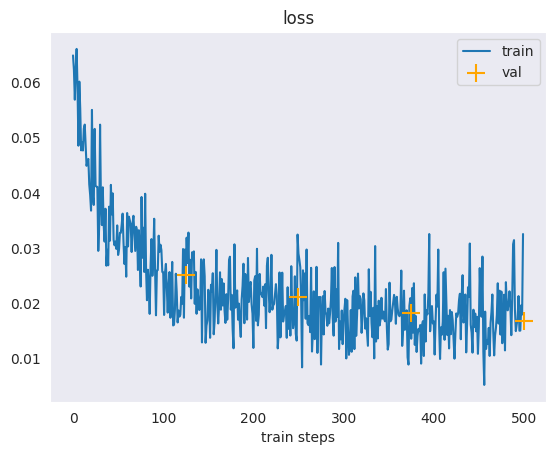

 13%|█▎        | 4/30 [01:40<08:55, 20.60s/it]

Train loss: 1.7568625158859879
Val loss: 1.68089775036356
Train acc: tensor(82.7655, device='cuda:0')
Val acc: tensor(83.9679, device='cuda:0')


In [ ]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model,
                                                                 criterion,
                                                                optimizer,
                                                                 train_loader,
                                                                 valid_loader,
                                                                 30)

## Посмотрим метрики нашей итоговой модели на валидации.

In [30]:
model.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

100%|██████████| 32/32 [00:01<00:00, 22.87it/s]


In [31]:
valid_df["pred"] = valid_predicts

In [32]:
valid_df["pred"]

3697    3
3755    7
244     1
726     1
1278    5
       ..
1057    4
1763    4
2056    6
4087    3
4363    3
Name: pred, Length: 998, dtype: int64

# Посчитаем recall

In [33]:
from sklearn.metrics import recall_score

In [34]:
val_accuracy = recall_score(valid_df['class'].values, valid_df['pred'].values, average = "macro")
print(f"Validation accuracy = {val_accuracy}")

Validation accuracy = 0.8045962522040059


## Предскажем для теста

In [35]:
test_df = pd.read_csv(PATH_TEST)
test_df = test_df.drop(["class"], axis = 1)

In [36]:
class TestImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_name = self.data_df.iloc[idx]['ID_img']
        
        # читаем картинку
        image = cv2.imread(DIR_TEST+ f"{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.data_df)

In [37]:
test_dataset = TestImageDataset(test_df, valid_transform)

In [38]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=32,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

#Предсказываем нашей моделью результат

In [39]:
model.eval()
predicts = []

for imgs in tqdm(test_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)
    for class_obj in pred:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      predicts.append(index)

100%|██████████| 67/67 [00:02<00:00, 23.39it/s]


In [40]:
test_df["class"] = predicts

test_df.head()

,ID_img,class
0,0.jpg,5
1,1.jpg,2
2,2.jpg,1
3,3.jpg,3
4,4.jpg,6


In [42]:
test_df.to_csv(".submit.csv", index=False)

In [6]:
class Customer:
    def __init__(self, name, balance=0):
        self.name = name
        self.balance = balance

    @staticmethod
    def check_type(a):
        if not isinstance(a, (int, float)):
            raise TypeError('Банк работает только с числами')

    def withdraw(self, s):
        Customer.check_type(s)
        if self.balance < s:
            raise ValueError('Сумма списания превышает баланс')
        else:
            self.balance -=s

    def deposit(self, d):
        Customer.check_type(d)
        self.balance +=d

bob = Customer('Bob Odenkirk')
# bob.deposit('hello') # TypeError: Банк работает только с числами
bob.deposit(200)
print(bob.balance)  # 200
# bob.withdraw(300)  # ValueError: Сумма списания превышает баланс
bob.withdraw(150)
print(bob.balance)  # 50

200
50


In [1]:
from dataclasses import dataclass

In [4]:
@dataclass
class Location:
    name: str
    longitude: float = 0
    latitude: float = 11.5

stonehenge = Location(name='Stonehenge', longitude=51, latitude=1.5 )
print(stonehenge)

Location(name='Stonehenge', longitude=51, latitude=1.5)
